In [1]:
import requests
import geopandas as gpd
from shapely.geometry import LineString
# chile

pa = [-33.437415, -70.651278] #plaza de armas
pm = [-33.442821, -70.654212] #palacio de la moneda


c:\Users\Jhon\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Jhon\AppData\Local\Temp\ipykernel_14052\1076762380.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should b

In [2]:
reversed(pa)

In [3]:
url = 'http://127.0.0.1:5000/route/v1/driving/'
url += f'{pa[1]},{pa[0]};{pm[1]},{pm[0]}?steps=true&geometries=geojson&annotations=duration&alternatives=false'
url

'http://127.0.0.1:5000/route/v1/driving/-70.651278,-33.437415;-70.654212,-33.442821?steps=true&geometries=geojson&annotations=duration&alternatives=false'

In [5]:
r = requests.get(url)
rjson = r.json()
crs_lat='EPSG:4326'
crs_moll='EPSG:3857'

In [28]:
rjson['routes'][0]

{'distance': 966.3,
 'duration': 82.5,
 'weight': 82.5,
 'weight_name': 'routability',
 'geometry': {'type': 'LineString',
  'coordinates': [[-70.651289, -33.437346],
   [-70.655525, -33.437813],
   [-70.6552, -33.440059],
   [-70.654618, -33.442303],
   [-70.654515, -33.44286]]},
 'legs': [{'distance': 966.3,
   'duration': 82.5,
   'weight': 82.5,
   'summary': 'Catedral, Teatinos',
   'steps': [{'mode': 'driving',
     'distance': 396.6,
     'duration': 37.2,
     'intersections': [{'location': [-70.651289, -33.437346],
       'bearings': [262],
       'entry': [True],
       'out': 0},
      {'location': [-70.652651, -33.437503],
       'in': 0,
       'bearings': [75, 180, 255],
       'entry': [False, False, True],
       'out': 2},
      {'location': [-70.654023, -33.437657],
       'in': 1,
       'bearings': [0, 75, 180, 270],
       'entry': [True, False, False, True],
       'out': 3},
      {'location': [-70.654779, -33.437736],
       'in': 0,
       'bearings': [90, 165,

<Axes: >

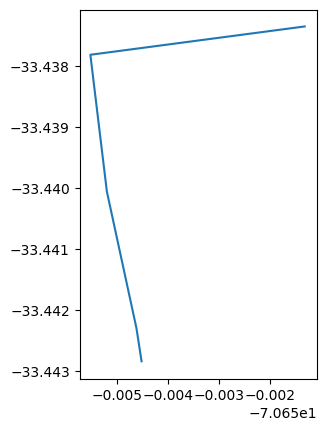

In [6]:
route = rjson['routes'][0]['geometry']['coordinates']
# route.append([-66.744416, -54.975603])dd
line = gpd.GeoDataFrame(geometry=[LineString(route)]).set_crs(crs_lat)
line.plot()

In [20]:
from shapely.geometry import Point, LineString
from shapely import  Polygon
import numpy as np
#params

radius_km = 10

n_grid = radius_km * 2
radius_km = radius_km * 1000
initial_center = Point(pa)
crs_moll='EPSG:3857'
crs_lat='EPSG:4326'

point_center = gpd.GeoSeries(initial_center, crs=crs_lat)\
	.to_crs(crs_moll)\
		.buffer(radius_km, cap_style=3)
minX, minY, maxX, maxY = point_center.total_bounds
size_grid_km = (maxY - minY) / n_grid
cols_grid=list(np.arange(minX, maxX, size_grid_km))
rows_grid=list(np.arange(minY, maxY, size_grid_km))


def make_grid(x, y, size_grid):
	coords_pol = [
		(x, y), (x + size_grid, y), 
		(x + size_grid, y + size_grid), 
		(x, y + size_grid)]
	center = size_grid / 2
	coords_center = [x + center, y + center] 
	coords_center = Point(coords_center)
	pc = gpd.GeoSeries(coords_center, crs=crs_moll)\
		.to_crs(crs_lat)
	lat, lon = pc.x, pc.y
	destiny = list(np.array([lat, lon]).flatten())
	pc_list = pc.tolist()
	pol = Polygon(coords_pol)
	gdf = gpd.GeoDataFrame({'geometry': pol}, index=[0])\
		.set_crs(crs_moll)\
		.to_crs(crs_lat)
	return destiny#pc#gdf, pc_list, 	
final = make_grid(cols_grid[0], rows_grid[1], size_grid_km)

In [51]:
# pa, final
begin_ = pa.copy()

In [44]:
def get_route(from_, to_, how='driving'):
	
	url = f'http://127.0.0.1:5000/route/v1/{how}/'
	url += f'{from_[1]},{from_[0]};{to_[1]},{to_[0]}?steps=true&geometries=geojson&annotations=duration&alternatives=false'

	r = requests.get(url)
	rjson = r.json()
	crs_lat='EPSG:4326'
	crs_moll='EPSG:3857'
	info = rjson['routes'][0]
	dist = info['distance']
	route = info['geometry']['coordinates']
	# route.append([-66.744416, -54.975603])dd
	line = gpd.GeoDataFrame(geometry=[LineString(route)]).set_crs(crs_lat)
	line = line.assign(
		dist_km=dist/1000, x = to_[0], y = to_[1],
		x_begin = from_[0], y_begin = from_[1]
	)
	return line

In [45]:
final_routes = []
for x in cols_grid:
	for y in rows_grid:
		final = make_grid(x, y, size_grid_km)
		final_routes.append(final)
# final_routes
# get_route(pa, final)

In [52]:
import pandas as pd
all_routes_df = gpd.GeoDataFrame()
for final in final_routes:
	all_routes_df = \
		pd.concat([all_routes_df, get_route(begin_, final)])

<Axes: >

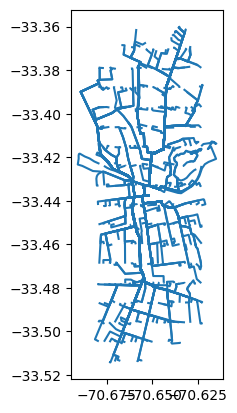

In [75]:
border = []
import alphashape
a = all_routes_df.query('dist_km < 10')
for _, row in a.iterrows():
	border.append((row['x'], row['y']))
bd = alphashape.alphashape(border, 60)
gdf = gpd.GeoDataFrame(geometry=[bd]).\
	set_crs(crs_lat, allow_override=True)

<Axes: >

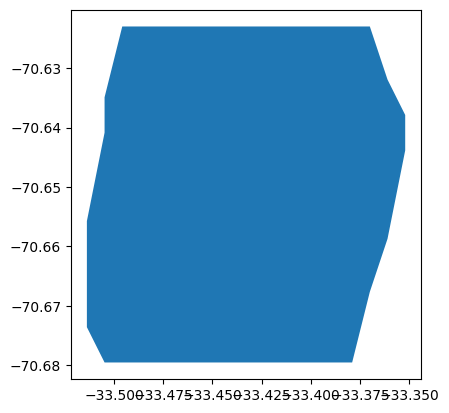

In [76]:
gdf.plot()